In [116]:
import statistics
import torch
from torch import nn, optim
import json
from tqdm.auto import tqdm, trange

device = 'cuda'

In [128]:
if torch.cuda.is_available():
    device_count = torch.cuda.device_count()
    print(f"Number of available GPUs: {device_count}")
    
    for i in range(device_count):
        device_name = torch.cuda.get_device_name(i)
        print(f"Device {i}: {device_name}")
else:
    print("No GPUs available")

Number of available GPUs: 1
Device 0: NVIDIA GeForce RTX 3050 Ti Laptop GPU


In [117]:
MESSAGE_MARKER = '>' # start or end of message


def load_dialogues(fname: str) -> list[str]:
    with open(fname, encoding='utf8') as f:
        data = list(json.load(f).values())
    
    output = []
    for entry in data:
        dialogue = "".join([MESSAGE_MARKER + t for t in entry['turns']]) + MESSAGE_MARKER
        output.append(dialogue)
    return output


train_dialogues = load_dialogues('dialogues/data/train.json')
test_dialogues = load_dialogues('dialogues/data/test.json')
valid_dialogues = load_dialogues('dialogues/data/valid.json')

print("TRAIN DIALOGUES COUNT:", len(train_dialogues))
print("example:", train_dialogues[0])

TRAIN DIALOGUES COUNT: 9058
example: >I know what she was going through was hard but this is just a temporary feeling>And she is young indeed.>everything will be okay. I'll be there for her>It must hurt so much now though>I told her that after every bad thing that happens, there is good that happens. She is a good person and good things will happen to her>Kai that was really thoughtful of you>


In [118]:
OOA = '\0' # out of alphabet

alphabet = set(
    char
    for dialogue in train_dialogues
    for char in dialogue
)
alphabet.add(OOA)

index_to_char = sorted(alphabet)
char_to_index = {v:k for k, v in enumerate(index_to_char)}

OOA_INDEX = char_to_index[OOA]


print("Alphabet:", "".join(index_to_char))
print("Alphabet size:", len(alphabet))

assert 'a' == index_to_char[char_to_index['a']]

Alphabet:   !"#$%&')+,-./0123456789:;=>?ABCDEFGHIJKLMNOPQRSTUVWXYZ`abcdefghijklmnopqrstuvwxyzé’“”
Alphabet size: 87


In [119]:
eye = torch.eye(len(alphabet))

def tensors_dataset(dialogues: list[str]):
    xs, ys = [], []
    for dialogue in dialogues:
        indicies = [char_to_index.get(c, OOA_INDEX) for c in dialogue]

        input_tensor = torch.stack([eye[i] for i in indicies[:-1]]).to(device)
        target_tensor = torch.tensor(indicies[1:]).to(device)

        xs.append(input_tensor)
        ys.append(target_tensor)

    return xs, ys

x_train, y_train = tensors_dataset(train_dialogues)
x_test, y_test = tensors_dataset(test_dialogues)
x_valid, y_valid = tensors_dataset(valid_dialogues)

# test 15's row
assert torch.allclose(torch.argmax(x_test[0], dim=1)[1:], y_test[0][:-1])

In [120]:
class CharGenRNN(nn.Module):
    def __init__(
            self,
            alphabet_size,
            hidden_size,
            dropout=0.2,
        ) -> None:
        super().__init__()
        self.rnn = nn.RNN(
            input_size=alphabet_size,
            hidden_size=hidden_size,
            num_layers=1,
            batch_first=True,
            dropout=dropout,
            bidirectional=False,
        )
        self.o2o = nn.Linear(hidden_size, alphabet_size)
        self.softmax = nn.LogSoftmax(dim=-1)

    def forward(self, input_tensor, h0=None):
        if h0 is None:
            rnn_out, hidden = self.rnn(input_tensor) # shape: (seq_len, hidden_size)
        else:
            rnn_out, hidden = self.rnn(input_tensor, h0)
        lin_out = self.o2o(rnn_out) # shape (seq_len, alphabet_size)
        log_probs = self.softmax(lin_out) # shape (seq_len, )
        return log_probs, hidden


In [121]:
model = CharGenRNN(
    alphabet_size=len(alphabet),
    hidden_size=250,
).to(device)

In [122]:
loss_save_freq = 100
loss_print_freq = 500
total_batches = len(x_train)
epochs = 5


loss_fn = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

train_losses = []
test_losses = []

i = 0
for e in trange(epochs):
    model.train()
    for x, y in tqdm(zip(x_train, y_train), total=len(x_train)):

        y_hat, _ = model(x)

        loss = loss_fn(y_hat, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


        i += 1
        if i % loss_save_freq == 0:
            train_losses.append(loss.item())

        if i % loss_print_freq == 0:
            tqdm.write(f"TRAIN LOSS: {loss.item()}")
    
    model.eval()
    with torch.no_grad():
        for x, y in tqdm(zip(x_test, y_test), total=len(x_test)):

            y_hat, _ = model(x)
            loss = loss_fn(y_hat, y)
            test_losses.append(loss.item())
        
    print("TEST LOSS", test_losses[-1])


valid_losses = []

model.eval()
with torch.no_grad():
    for x, y in tqdm(zip(x_valid, y_valid), total=len(x_valid)):

        y_hat, _ = model(x)
        loss = loss_fn(y_hat, y)
        valid_losses.append(loss.item())
    
print("VALID LOSS AVERAGE", statistics.mean(valid_losses))

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/9058 [00:00<?, ?it/s]

TRAIN LOSS: 2.403893232345581
TRAIN LOSS: 1.9799830913543701
TRAIN LOSS: 1.885400652885437
TRAIN LOSS: 1.7888001203536987
TRAIN LOSS: 1.6991878747940063
TRAIN LOSS: 1.9283522367477417
TRAIN LOSS: 1.672491192817688
TRAIN LOSS: 1.7335901260375977
TRAIN LOSS: 1.8698668479919434
TRAIN LOSS: 1.5695844888687134
TRAIN LOSS: 1.6588698625564575
TRAIN LOSS: 1.6795867681503296
TRAIN LOSS: 1.7655162811279297
TRAIN LOSS: 1.575900673866272
TRAIN LOSS: 1.4188232421875
TRAIN LOSS: 1.5220669507980347
TRAIN LOSS: 1.6820871829986572
TRAIN LOSS: 1.6174116134643555


  0%|          | 0/1158 [00:00<?, ?it/s]

TEST LOSS 1.6404445171356201


  0%|          | 0/9058 [00:00<?, ?it/s]

TRAIN LOSS: 1.4351884126663208
TRAIN LOSS: 1.4507837295532227
TRAIN LOSS: 1.5965747833251953
TRAIN LOSS: 1.6242010593414307
TRAIN LOSS: 1.2662433385849
TRAIN LOSS: 1.3437795639038086
TRAIN LOSS: 1.3402047157287598
TRAIN LOSS: 1.3164453506469727
TRAIN LOSS: 1.4391274452209473
TRAIN LOSS: 1.324491024017334
TRAIN LOSS: 1.3179893493652344
TRAIN LOSS: 1.515682578086853
TRAIN LOSS: 1.417097806930542
TRAIN LOSS: 1.3541160821914673
TRAIN LOSS: 1.3193130493164062
TRAIN LOSS: 1.675469160079956
TRAIN LOSS: 1.1829668283462524
TRAIN LOSS: 1.4176658391952515


  0%|          | 0/1158 [00:00<?, ?it/s]

TEST LOSS 1.5472562313079834


  0%|          | 0/9058 [00:00<?, ?it/s]

TRAIN LOSS: 1.3597992658615112
TRAIN LOSS: 1.456323504447937
TRAIN LOSS: 1.3891963958740234
TRAIN LOSS: 1.39525306224823
TRAIN LOSS: 1.3133740425109863
TRAIN LOSS: 1.4499046802520752
TRAIN LOSS: 1.1224799156188965
TRAIN LOSS: 1.317813515663147
TRAIN LOSS: 1.3598887920379639
TRAIN LOSS: 1.3145349025726318
TRAIN LOSS: 1.2508045434951782
TRAIN LOSS: 1.2339205741882324
TRAIN LOSS: 1.2009451389312744
TRAIN LOSS: 1.2902785539627075
TRAIN LOSS: 1.3313043117523193
TRAIN LOSS: 1.4108527898788452
TRAIN LOSS: 1.1962541341781616
TRAIN LOSS: 1.4306977987289429


  0%|          | 0/1158 [00:00<?, ?it/s]

TEST LOSS 1.5500669479370117


  0%|          | 0/9058 [00:00<?, ?it/s]

TRAIN LOSS: 1.0717735290527344
TRAIN LOSS: 1.1617496013641357
TRAIN LOSS: 1.2512198686599731
TRAIN LOSS: 1.4115039110183716
TRAIN LOSS: 1.4589661359786987
TRAIN LOSS: 1.2000732421875
TRAIN LOSS: 1.4740684032440186
TRAIN LOSS: 1.277725338935852
TRAIN LOSS: 1.2597633600234985
TRAIN LOSS: 1.4563664197921753
TRAIN LOSS: 1.5244910717010498
TRAIN LOSS: 1.3281453847885132
TRAIN LOSS: 1.1250399351119995
TRAIN LOSS: 1.1882046461105347
TRAIN LOSS: 1.478305697441101
TRAIN LOSS: 1.2000726461410522
TRAIN LOSS: 1.3037004470825195
TRAIN LOSS: 1.358464002609253


  0%|          | 0/1158 [00:00<?, ?it/s]

TEST LOSS 1.5316721200942993


  0%|          | 0/9058 [00:00<?, ?it/s]

TRAIN LOSS: 1.1353048086166382
TRAIN LOSS: 1.4999960660934448
TRAIN LOSS: 1.209424376487732
TRAIN LOSS: 1.4897089004516602
TRAIN LOSS: 1.2204620838165283
TRAIN LOSS: 1.1335841417312622
TRAIN LOSS: 1.2352819442749023
TRAIN LOSS: 1.336439847946167
TRAIN LOSS: 1.2493829727172852
TRAIN LOSS: 1.26239013671875
TRAIN LOSS: 1.4711376428604126
TRAIN LOSS: 1.3183082342147827
TRAIN LOSS: 1.343779444694519
TRAIN LOSS: 1.3497940301895142
TRAIN LOSS: 1.3458887338638306
TRAIN LOSS: 1.2977252006530762
TRAIN LOSS: 1.1650691032409668
TRAIN LOSS: 1.3494302034378052


  0%|          | 0/1158 [00:00<?, ?it/s]

TEST LOSS 1.5464240312576294


  0%|          | 0/1157 [00:00<?, ?it/s]

VALID LOSS AVERAGE 1.3276814011633138


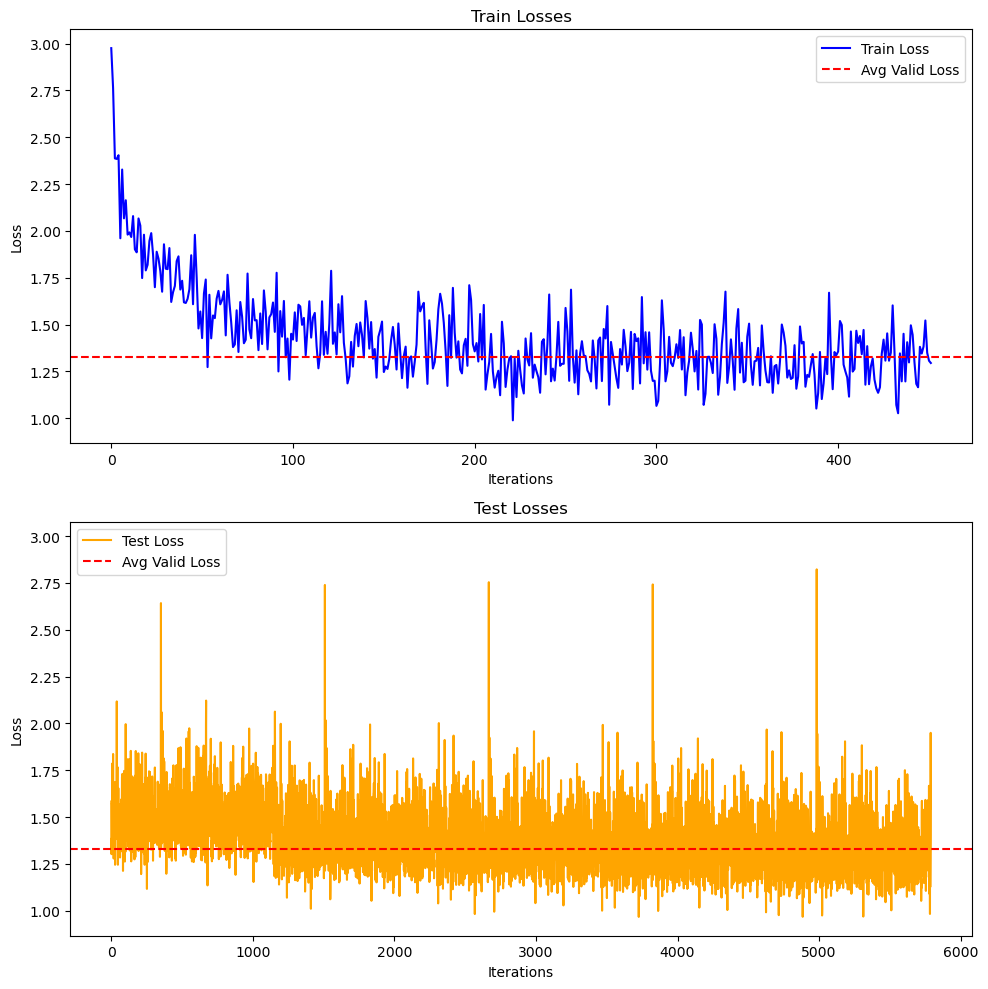

In [127]:
import matplotlib.pyplot as plt


fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10), sharey=True)

ax1.plot(train_losses, label="Train Loss", color='blue')
ax1.axhline(y=statistics.mean(valid_losses), color='r', linestyle='--', label="Avg Valid Loss")
ax1.set_xlabel("Iterations")
ax1.set_ylabel("Loss")
ax1.set_title("Train Losses")
ax1.legend()

ax2.plot(test_losses, label="Test Loss", color='orange')
ax2.axhline(y=statistics.mean(valid_losses), color='r', linestyle='--', label="Avg Valid Loss")
ax2.set_xlabel("Iterations")
ax2.set_ylabel("Loss")
ax2.set_title("Test Losses")
ax2.legend()

plt.tight_layout()
plt.show()

In [124]:
torch.save(model, 'dialogue.model')

In [125]:
def to_input_tensor(s: str) -> torch.Tensor:
    indicies = [char_to_index[c] for c in s]
    return torch.stack([eye[i] for i in indicies])


def append_context(
        model: CharGenRNN,
        input_tensor: torch.Tensor,
        old_context: torch.Tensor
    ) -> torch.Tensor:
    _, hidden = model(input_tensor, old_context)
    return hidden


hidden = torch.zeros(1, 250).to(device)
MAX_ANS_LEN = 250
last_letter = ''

with torch.no_grad():
    while True:
        prefix = '>' if last_letter != '>' else ''
        question = "Something bad happened" #input('Q> ')
        input_tensor = to_input_tensor(prefix + question + MESSAGE_MARKER).to(device)
        hidden = append_context(model, input_tensor, hidden)

        letter = None
        ans_length = 0
        for _ in range(MAX_ANS_LEN):
            output, hidden = model(input_tensor, hidden)

            topv, topi = output.topk(1)

            char_index = topi[0][0]
            letter = index_to_char[char_index]
            print(letter, end='')
            last_letter = letter
            if letter == MESSAGE_MARKER:
                break
            input_tensor = to_input_tensor(letter).to(device)
        break


I know you were the car and I was so happy to be at the care of the care of the care of the care of the care of the care of the care of the care of the care of the care of the care of the care of the care of the care of the care of the care of the ca